### Upsetplots for Identifications per confidence type

Tier 1, canonical: 19722
Tier 2, indistinguishable representative: 3382
Tier 6, insufficient evidence: 302
Tier 4, marginally distinguished: 4456
Tier 1, canonical: 1832
Tier 3, representative: 0
Tier 8, subsumed: 10557
Tier 5, weak: 2067


Presence levels:
1. Identical
2. Indistinguishable


In [11]:
import pandas as pd
from pathlib import Path
from upsetplot import plot, UpSet, from_contents
import warnings
import matplotlib.pyplot as plt
import matplotlib

In [12]:
# filter FutureWarnings from pandas, otherwise notebook gets crowded
warnings.filterwarnings('ignore', category=FutureWarning)

In [13]:
folder = "../data/Fig1_Strain_proteome_coverage/per_evidence_level"
files = Path(folder).glob("*.tsv")

IDs = {}

for file in files:
    name = file.name
    name = name.replace(".tsv", "").replace("PA2_", "")
    IDs[name] = pd.read_table(file)
    # filter out phages
    IDs[name] = IDs[name][~IDs[name]["biosequence_name"].str.contains("PHAGE_sp")]

IDs["uncertain"] = pd.concat([IDs["weak"], IDs["insufficient_evidence"], IDs["subsumed"], IDs["indistinguishable_representative"]])
del IDs["insufficient_evidence"]
del IDs["subsumed"]
del IDs["indistinguishable_representative"]
del IDs["weak"]

IDs["canonical"] = pd.concat([IDs["canonical"], IDs["noncore_canonical"]])
del IDs["noncore_canonical"]

IDs["indistinguishable_from_canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] == "indistinguishable"]
IDs["canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] != "indistinguishable"]

IDs["uncertain"] = pd.concat([IDs["uncertain"], IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] == "indistinguishable"]])
IDs["marginally_distinguished"] = IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] != "indistinguishable"]

IDs["indistinguishable_from_canonical"]["presence_level"] = "indistinguishable_from_canonical"
IDs["canonical"]["presence_level"] = "canonical"
IDs["marginally_distinguished"]["presence_level"] = "marginally_distinguished"
IDs["uncertain"]["presence_level"] = "uncertain"

del IDs["all_tiers"]

for key in IDs:
    print(f'{key}: {len(IDs[key])}')

presence_levels = pd.concat([IDs["canonical"], IDs["indistinguishable_from_canonical"], IDs["marginally_distinguished"], IDs["uncertain"]])

# to dict
presence_levels = presence_levels.drop(columns=["relationship_phrase"])
presence_dict = pd.Series(presence_levels.presence_level.values,index=presence_levels.biosequence_name).to_dict()

canonical: 19171
marginally_distinguished: 4207
uncertain: 16272
indistinguishable_from_canonical: 2409


In [14]:
strains = ["K12", "MC4100", "BL21", "NC101", "O127H6", "APEC", "ATCC25922", "BW25113", "NCM3722", "W3110", "AB1157", "DH5", "ST73", "ST93", "ST131", "ST1421"]

def parse_clstr_file(filename):

    df = pd.DataFrame(columns=["cluster"] + strains)

    current_cluster = None  # Variable to keep track of the current cluster being processed

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('>Cluster'):
                current_cluster = line.strip().split(' ')[1]  # Extract the cluster number
                # add row to df
                df = pd.concat([df, pd.DataFrame([[current_cluster] + [0]*len(strains)], columns=["cluster"] + strains)], ignore_index=True)
            else:
                # Extract the strain name from the line
                strain = line.split('>')[1].split('_')[0]

                # Extract the protein ID from the line
                if ">ST" in line:
                    # e.g. >ST73_ECFI4_00021... at 100.00%
                    protein_id = "_".join(line.split('_')[1:3]).split('...')[0]
                elif "|" in line:
                    # e.g. >APEC_sp|A1A7A0|RSMA_ECOK1_00001... at 0.000
                    # or >K12_sp|P0CE51|INSH3_ECOLI
                    protein_id = line.split("|")[1]
                else:
                    # e.g. >ATCC25922_UPI00001363DE... at 0.000
                    protein_id = line.split('_')[1].split('...')[0]

                # set the strain to 1 in df
                df.loc[df["cluster"] == current_cluster, strain] = protein_id

    return df

In [15]:
def retrieve_highest_evidence_level(row, use_highest_evidence_level=True):
    evidence_levels = set()
    for strain in strains:
        if row[strain] != 0:
            try:
                evidence_levels.add(presence_dict[row[strain]])
            except KeyError:
                evidence_levels.add("not observed")

    if use_highest_evidence_level:
        if "canonical" in evidence_levels:
           return "canonical"
        elif "indistinguishable_from_canonical" in evidence_levels:
            return "indistinguishable from canonical"
        elif "marginally_distinguished" in evidence_levels:
           return "marginally distinguished"
        elif "uncertain" in evidence_levels:
            return "uncertain"
        elif "not observed" in evidence_levels:
            return "not observed"

    else:
        if "not observed" in evidence_levels:
            return "not observed"
        elif "uncertain" in evidence_levels:
            return "uncertain"
        elif "marginally_distinguished" in evidence_levels:
            return "marginally distinguished"
        elif "indistinguishable_from_canonical" in evidence_levels:
            return "indistinguishable from canonical"
        elif "canonical" in evidence_levels:
            return "canonical"

    return evidence_levels

In [16]:
def plot_cluster(threshold, min_proteins = 1, min_degree = 1000, show_counts = False, use_highest_evidence_level = True):
    filename = "../data/Fig3D_SupplFig2_upsetplots/cdhit_stains_prefixed_cdhit_c{}.fasta.clstr".format(threshold)
    df = parse_clstr_file(filename)#, identified_proteins = IDs[classification]["biosequence_name"].tolist())
    df["evidence_levels"] = df.apply(lambda x: retrieve_highest_evidence_level(x, use_highest_evidence_level), axis=1)

    # replace every protein with "True" and every 0 with "False"
    df = df.drop(columns=["cluster"])
    for strain in strains:
        df[strain] = df[strain].apply(lambda x: True if x != 0 else False)

    df.columns = [col.replace("K12", "MG1655").replace("APEC", "APEC O1:K1") for col in df.columns]

    # turn to multiindex
    df2 = df.set_index( ["MG1655", "MC4100", "BL21", "NC101", "O127H6", "APEC O1:K1", "ATCC25922", "BW25113", "NCM3722", "W3110", "AB1157", "DH5", "ST73", "ST93", "ST131", "ST1421"]
)

    df2["evidence_levels"] = pd.Categorical(df2["evidence_levels"], categories=["canonical", "indistinguishable from canonical", "marginally distinguished", "uncertain", "not observed"])
    df2 = df2.sort_values(by="evidence_levels")

    upset = UpSet(df2, intersection_plot_elements=0, min_subset_size=min_proteins, min_degree=min_degree, show_counts=show_counts)  # disable the default bar chart
    upset.add_stacked_bars(
        by="evidence_levels", title="Proteoforms by evidence level", elements=10, colors={"canonical": "#2ca02c", "indistinguishable from canonical": "#974EA4", "marginally distinguished": "#ff7f0e", "uncertain": "#1f77b4", "not observed": "#D62628"}
    )
    upset.plot()

    plt.gca().get_legend().remove()

    # save as svg 
    #plt.savefig("upsetplot_{}_{}.svg".format(threshold, use_highest_evidence_level), bbox_inches='tight', dpi=300)

    plt.show()
    return

In [17]:
matplotlib.rcParams["font.size"] = 15

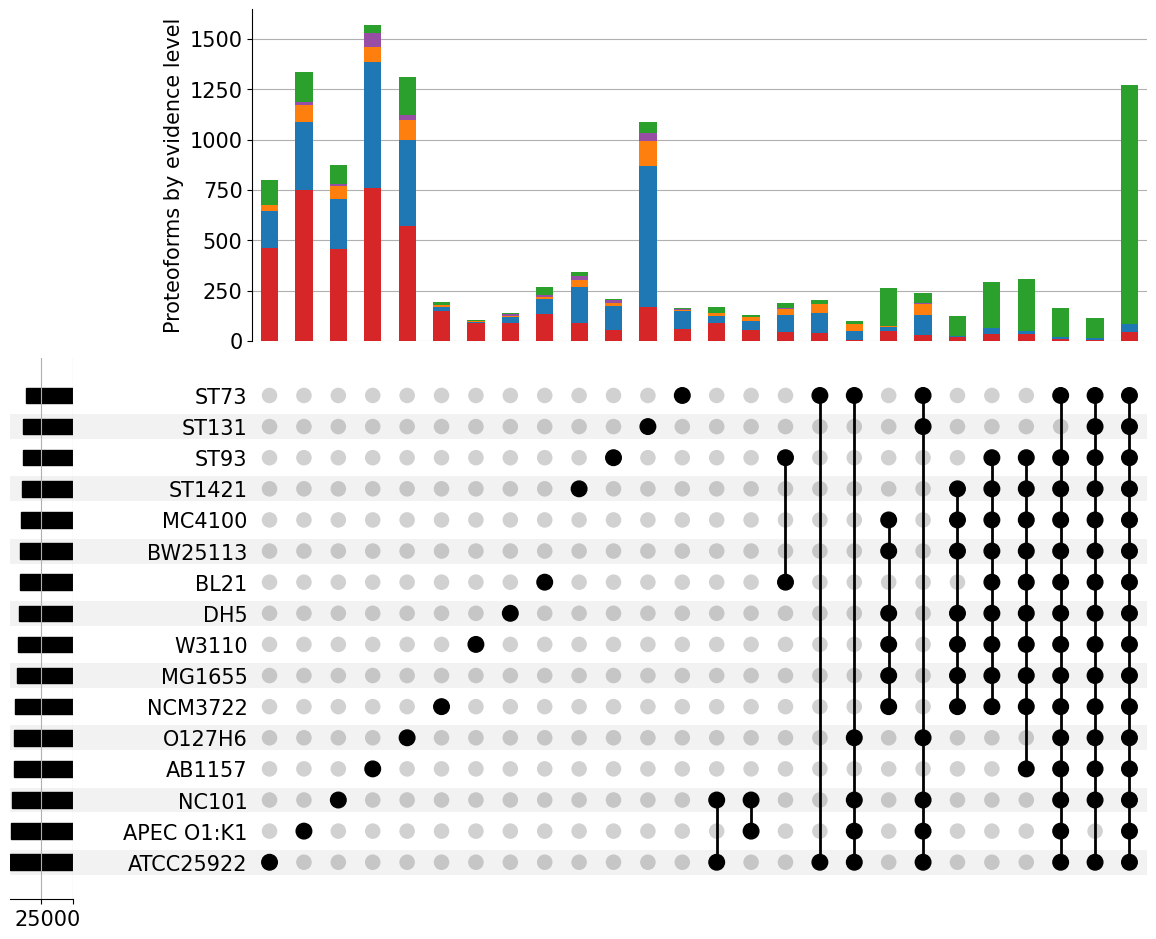

In [18]:
#Fig 3D1
plot_cluster(".99", min_proteins = 100, min_degree = 1, show_counts=False, use_highest_evidence_level=True)

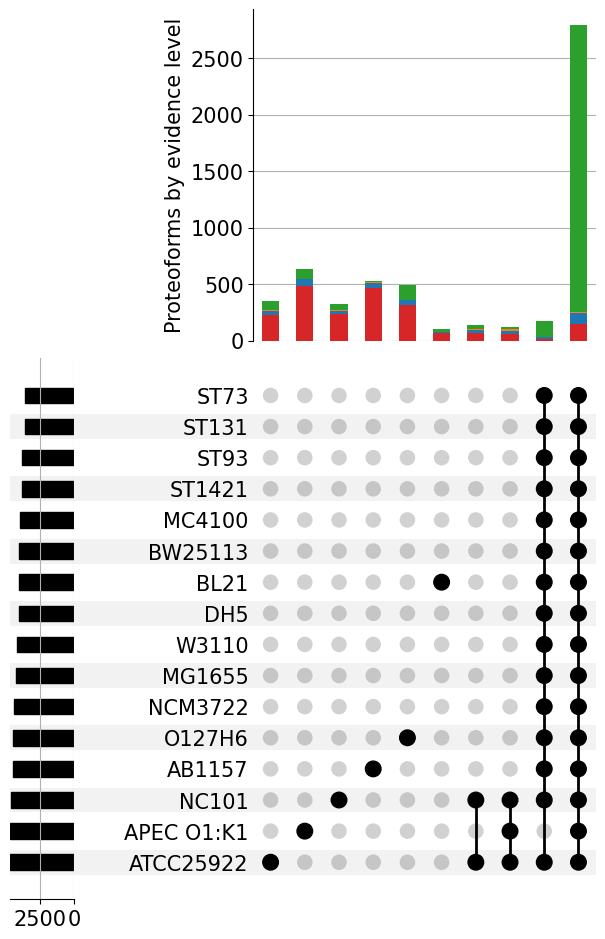

In [19]:
# Fig3D2
plot_cluster(".70", min_proteins = 100, min_degree = 1, show_counts=False)

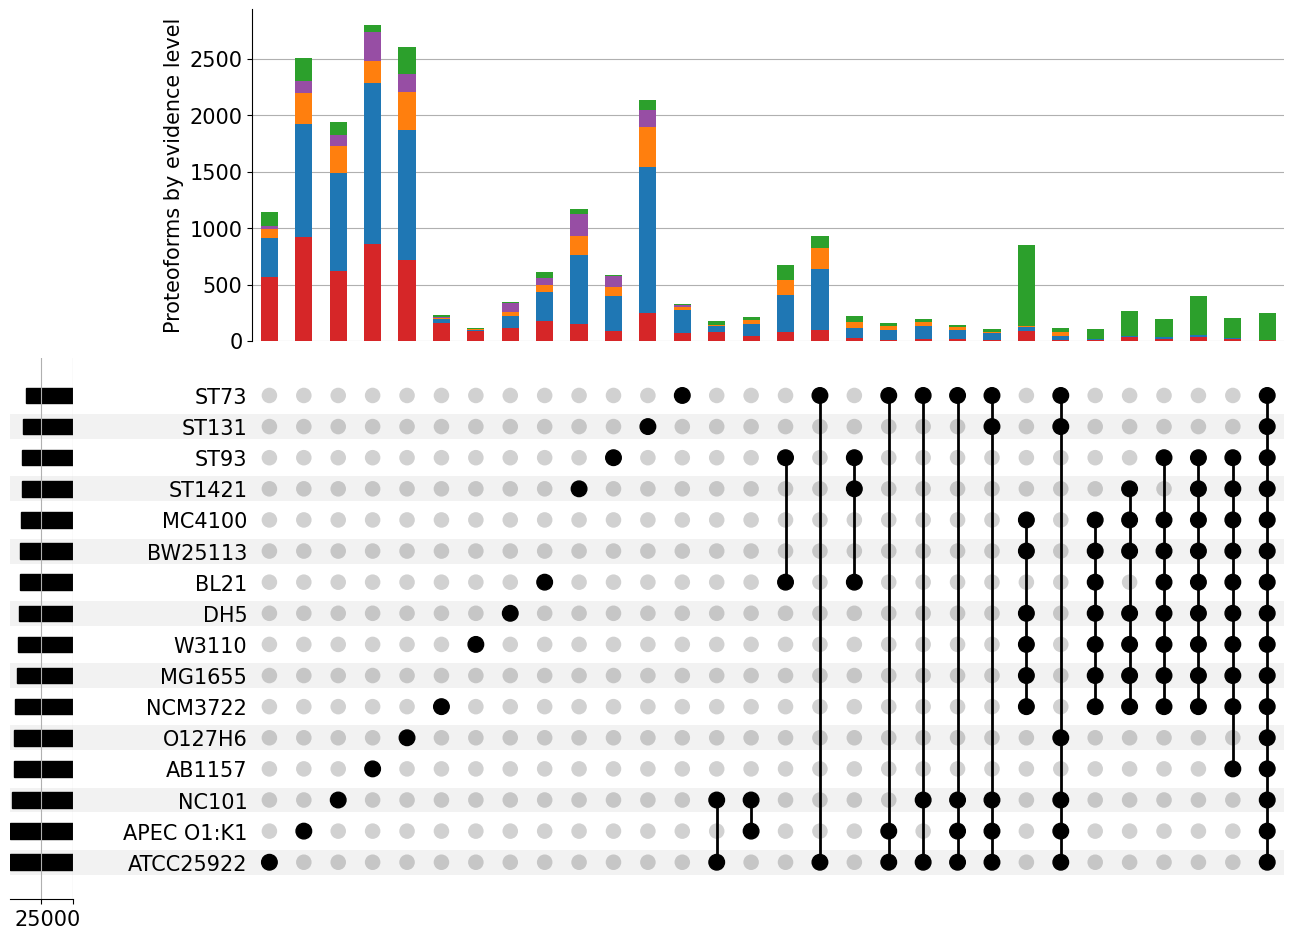

In [20]:
# SuppFig3
plot_cluster("1.00", min_proteins = 100, min_degree = 1, show_counts=False)